In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

In [2]:
df = load_proteome_as_df('Human')
print('complete length', '%e'%np.sum(df['Sequence'].str.len()))
print('multiple seqs', len(df['Sequence'])-len(df['Sequence'].unique()))
df.drop_duplicates(subset=['Sequence'], inplace=True)

df_clustered = load_proteome_as_df_path(datadir+'cluster/UP000005640Human_rep_seq.fasta')
print('>.9 identity', len(df)-len(df_clustered),
      '%e'%(np.sum(df['Sequence'].str.len())-np.sum(df_clustered['Sequence'].str.len())))


df_clustered_50 = load_proteome_as_df_path(datadir+'cluster/UP000005640Human_50_rep_seq.fasta')
print('>.5 identity', len(df_clustered)-len(df_clustered_50),
      '%e'%(np.sum(df_clustered['Sequence'].str.len())-np.sum(df_clustered_50['Sequence'].str.len())))

complete length 1.151849e+07
multiple seqs 66
>.9 identity 1289 4.566740e+05
>.5 identity 3486 1.973860e+06


In [3]:
# uniref viruses
#df = load_unirefproteome_as_df_path(datadir + 'human-viruses-uniref90.fasta')
#print('complete length', '%e'%np.sum(df['Sequence'].str.len()))

In [5]:
fragmentlength = 30
fragments = [kmer for kmer in to_kmers_nonoverlapping(df['Sequence'], fragmentlength)]
df_fragments = pd.DataFrame(dict(identifier=[str(i) for i in range(len(fragments))],
                                 Sequence=fragments))
df_fragments.drop_duplicates('Sequence', inplace=True)
fragmentlength*0.8, fragmentlength*0.8*0.5

(24.0, 12.0)

In [6]:
print('fragment length', '%e'%np.sum(df_fragments['Sequence'].str.len()))

fragment length 1.036833e+07


In [7]:
matrix_fragments = kmers_to_matrix(df_fragments['Sequence'])

In [8]:
aacounts_fragments = to_aacounts(matrix_fragments)

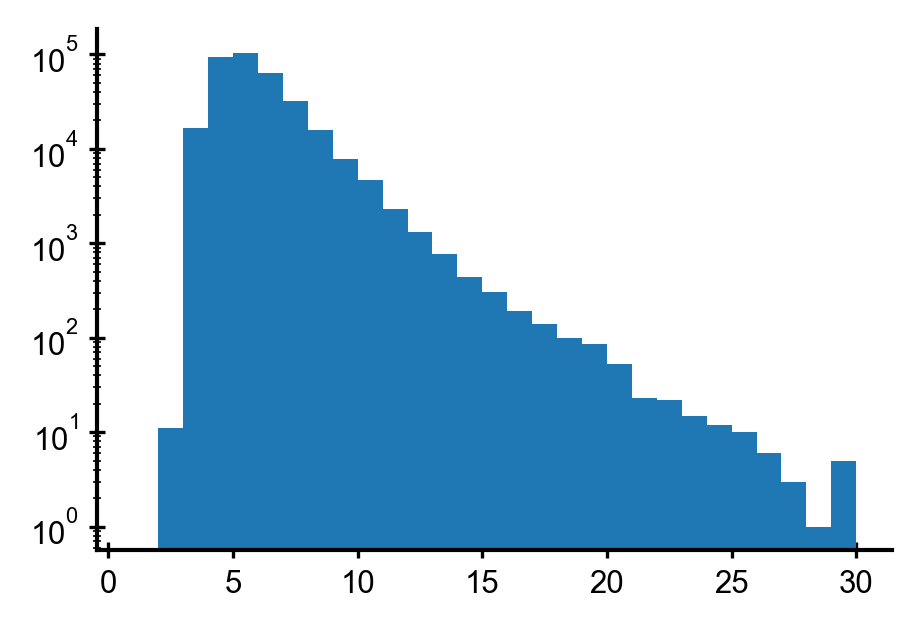

In [9]:
plt.hist(aacounts_fragments.max(axis=1), bins=np.arange(1, fragmentlength+1))
plt.yscale('log')

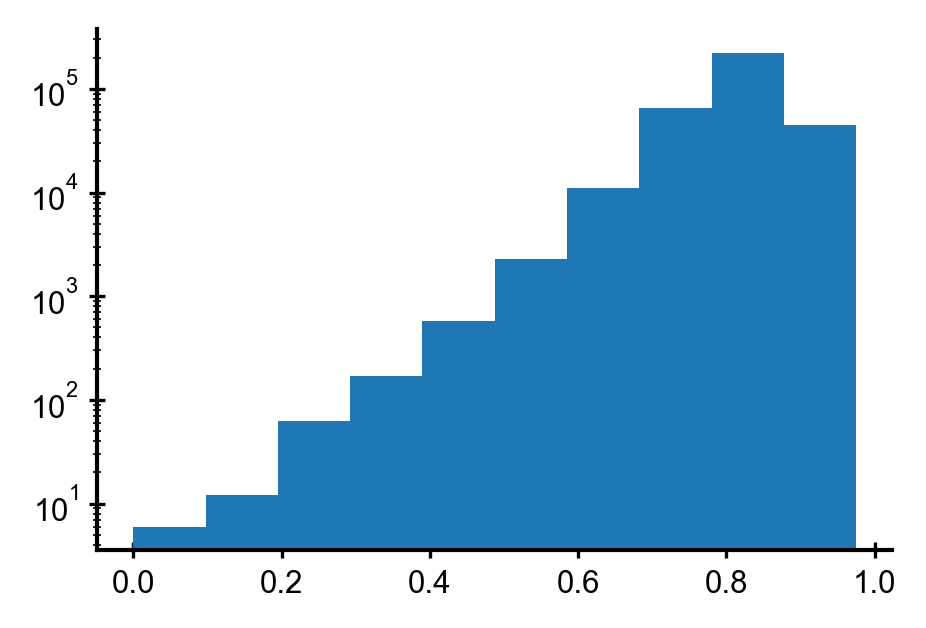

In [10]:
plt.hist(scipy.stats.entropy(aacounts_fragments/fragmentlength, axis=1, base=20))
plt.yscale('log')

In [11]:
write_fasta(df_fragments, 'fragments.fasta.gz', seqcolumn='Sequence', idcolumn='identifier')

In [12]:
!mmseqs easy-cluster fragments.fasta.gz fragments_50 tmp --min-seq-id 0.5 -c 0.8 --cov-mode 0 --comp-bias-corr 0

easy-cluster fragments.fasta.gz fragments_50 tmp --min-seq-id 0.5 -c 0.8 --cov-mode 0 --comp-bias-corr 0 

MMseqs Version:                     	12.113e3
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	0
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask lower case residues            	0
Minimum diagonal score              	15
Include i

Clustering mode: Set Cover
[=================================================================] 100.00% 306.92K 0s 27ms     
Sort entries
Find missing connections
Found 399 new connections.
Reconstruct initial order
[=================================================================] 100.00% 306.92K 0s 44ms     
Add missing connections
[=================================================================] 100.00% 306.92K 0s 19ms     

Time for read in: 0h 0m 0s 131ms
Total time: 0h 0m 0s 171ms

Size of the sequence database: 306923
Size of the alignment database: 306923
Number of clusters: 306546

Writing results 0h 0m 0s 47ms
Time for merging to clust: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 254ms
mergeclusters tmp/7888313341575019178/input tmp/7888313341575019178/clu_tmp/11386871211198906062/clu_redundancy tmp/7888313341575019178/clu_tmp/11386871211198906062/linclust/13286277366850465692/pre_clust tmp/7888313341575019178/clu_tmp/11386871211198906062/linclust/13286277366850465692/clust 

Process prefiltering step 1 of 1

k-mer similarity threshold: 145
Starting prefiltering scores calculation (step 1 of 1)
Query db start 1 to 298959
Target db start 1 to 298959
[=================================================================] 100.00% 298.96K 4s 521ms    

5.388852 k-mers per position
22 DB matches per sequence
0 overflows
0 queries produce too many hits (truncated result)
1 sequences passed prefiltering per query sequence
1 median result list length
0 sequences with 0 size result lists
Time for merging to pref_step1: 0h 0m 0s 86ms
Time for processing: 0h 0m 6s 334ms
align tmp/7888313341575019178/clu_tmp/11386871211198906062/input_step1 tmp/7888313341575019178/clu_tmp/11386871211198906062/input_step1 tmp/7888313341575019178/clu_tmp/11386871211198906062/pref_step1 tmp/7888313341575019178/clu_tmp/11386871211198906062/aln_step1 --sub-mat nucl:nucleotide.out,aa:blosum62.out -a 0 --alignment-mode 3 --wrapped-scoring 0 -e 0.001 --min-seq-id 0.5 --min-aln-len 0 --seq-id-mode 

Time for merging to clu: 0h 0m 0s 107ms
Time for processing: 0h 0m 0s 554ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/clu_redundancy -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/input_step_redundancy -v 3 

Time for processing: 0h 0m 0s 0ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/pref_step0 -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/aln_step0 -v 3 

Time for processing: 0h 0m 0s 2ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/clu_step0 -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/pref_step1 -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/aln_step1 -v 3 

Time for processing: 0h 0m 0s 3ms
rmdb tmp/7888313341575019178/clu_tmp/11386871211198906062/clu_step1 -v 3 

Time for processing: 0h 0m 0s 1ms
rmdb tmp/7888313341575019178/clu_

In [13]:
df_fragments_clustered = load_proteome_as_df_path('fragments_50_rep_seq.fasta',
                                                  parse_genes=False, parse_accessions=False)
print('fragment clustered length', '%e'%np.sum(df_fragments_clustered['Sequence'].str.len()))

fragment clustered length 8.720010e+06


In [14]:
def counter_to_series(counter):
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    count_series = count_df.T.squeeze()
    return count_series
def fraction_multiple(series):
    return np.sum(series[series>1])/np.sum(series)

In [15]:
k = 9
filterlength = 12

In [24]:
for d in [df,
          df_clustered, df_clustered_50,
          df_fragments_clustered]:
    count_series = counter_to_series(count_kmers_iterable(d['Sequence'], k, clean=True))
    count_series_unique = counter_to_series(
                       count_kmers_iterable(
                           filter_unique(d['Sequence'], k, filterlength),
                           k)
                       )
    print(fraction_multiple(count_series), fraction_multiple(count_series_unique),
          '{:.3e}, {:.3e}'.format(np.sum(count_series), np.sum(count_series_unique)))

0.1306002329393046 0.03224968388851347 1.133e+07, 1.054e+07
0.08191076940880623 0.02952183266376662 1.089e+07, 1.045e+07
0.046532402652476226 0.013728465192027481 8.942e+06, 8.712e+06
0.020524267538892523 0.005744686583619087 6.395e+06, 5.493e+06


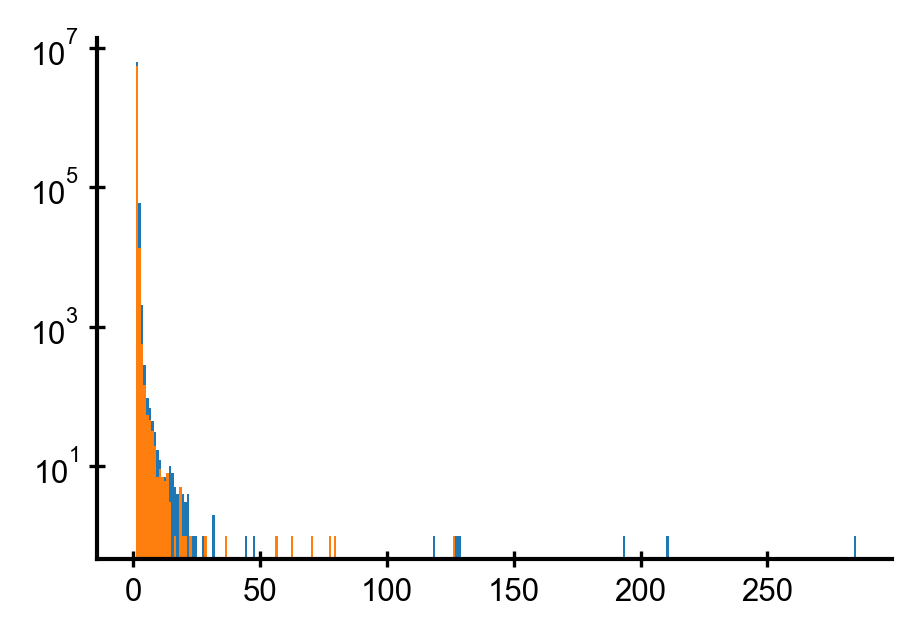

In [18]:
counts, bins, _ = plt.hist(count_series, log=True,
                           bins=np.arange(0, count_series.max()+1, 1));
plt.hist(count_series_unique, log=True, bins=bins);
#plt.xscale('log')

In [19]:
counts = count_series

In [20]:
2*np.sum(scipy.special.binom(counts[counts>1], 2))/np.sum(counts)**2

9.170774835399624e-09

In [21]:
'{:.3e}, {:.3e}'.format(np.sum(count_series), np.sum(count_series_unique))

'6.395e+06, 5.493e+06'

In [22]:
count_series.sort_values().tail(50)

PPPPPPLPP     14
PPLPPPPPP     14
EEEEEEEEG     14
PPPPPPPAP     14
PPPPPLPPP     14
EEDEEEEEE     14
AAAAAAAVA     15
EEEEEEEDD     15
PAPPPPPPP     15
GRGRGRGRG     15
VAAAAAAAA     15
PAAAAAAAA     15
PSSSSSSSS     15
PEPEPEPEP     15
RGRGRGRGR     16
SSSSSSSSP     16
SRSRSRSRS     16
QPPPPPPPP     16
EDEEEEEEE     16
PGPGPGPGP     17
APPPPPPPP     17
GPGPGPGPG     17
DSSDSSDSS     17
GEEEEEEEE     18
EEEDEEEEE     18
AAAAAAAAS     19
DEEEEEEEE     19
SDSSDSSDS     19
LPPPPPPPP     19
SGGGGGGGG     20
AAAAAAAAV     20
SSDSSDSSD     20
EEEEEEDEE     21
PGPPGPPGP     21
AAAAAAAAG     21
PPPPPPPPA     21
EEEEEEEDE     23
PLLLLLLLL     24
SAAAAAAAA     27
PPGPPGPPG     28
EEEEEEEED     31
GPPGPPGPP     31
HHHHHHHHH     44
LLLLLLLLL     47
GGGGGGGGG    118
PPPPPPPPP    127
QQQQQQQQQ    128
SSSSSSSSS    193
EEEEEEEEE    210
AAAAAAAAA    285
Name: count, dtype: int64

In [23]:
count_series_unique.sort_values().tail(20)

QPPPPPPPP     14
SRSRSRSRS     14
SGGGGGGGG     14
EEEEEEDEE     16
PPGPPGPPG     18
AAAAAAAAG     18
PPPPPPPPA     18
EEEEEEEDE     18
AAAAAAAAS     18
PLLLLLLLL     19
GPPGPPGPP     20
EEEEEEEED     22
HHHHHHHHH     28
LLLLLLLLL     36
GGGGGGGGG     56
QQQQQQQQQ     62
SSSSSSSSS     70
EEEEEEEEE     77
PPPPPPPPP     79
AAAAAAAAA    126
Name: count, dtype: int64